# Skin Disease Model

# Step 1: Import all the Dependencies



In [ ]:
import numpy as np
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K

In [ ]:
import zipfile
zip_file_path = '/content/archive (16).zip'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
  zip_ref.extractall('/content')

In [ ]:
INIT_LR = 0.000001
BATCH_SIZE = 32
EPOCHS = 50
IMAGE_SIZE =224
default_image_size = tuple((IMAGE_SIZE, IMAGE_SIZE))
image_size = 0
data_dir = "/content/skin-disease-datasaet/train_set"
CHANNELS=3
AUTOTUNE = tf.data.AUTOTUNE

# Step 2: Function to Split Dataset

In [ ]:
import tensorflow as tf

IMAGE_SIZE = 224
BATCH_SIZE = 32
SEED = 123

# Load full training dataset from train folder
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/skin-disease-datasaet/train_set",
    seed=SEED,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

# Load full test dataset from test folder
full_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/skin-disease-datasaet/test_set",
    seed=SEED,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=1,  # Important for selecting exact number of images
    shuffle=True   # Shuffle so we get random 20 images for test
)

# Flatten test dataset to individual images
full_test_ds = full_test_ds.unbatch()

# Take first 20 images for test
test_ds = full_test_ds.take(20).batch(BATCH_SIZE)

# Skip first 20 and use the rest as validation
val_ds = full_test_ds.skip(20).batch(BATCH_SIZE)

# Prefetch for performance
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)



Found 924 files belonging to 8 classes.
Found 233 files belonging to 8 classes.


#### Reading and Partitioning the Dataset

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=default_image_size,
  batch_size=BATCH_SIZE
)


train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

Found 924 files belonging to 8 classes.


#### Checking the Available Classes


In [ ]:

class_names = dataset.class_names
n_classes = len(class_names)
print(n_classes, class_names)

8 ['BA- cellulitis', 'BA-impetigo', 'FU-athlete-foot', 'FU-nail-fungus', 'FU-ringworm', 'PA-cutaneous-larva-migrans', 'VI-chickenpox', 'VI-shingles']


# Step 3: Displaying Some Sample Images


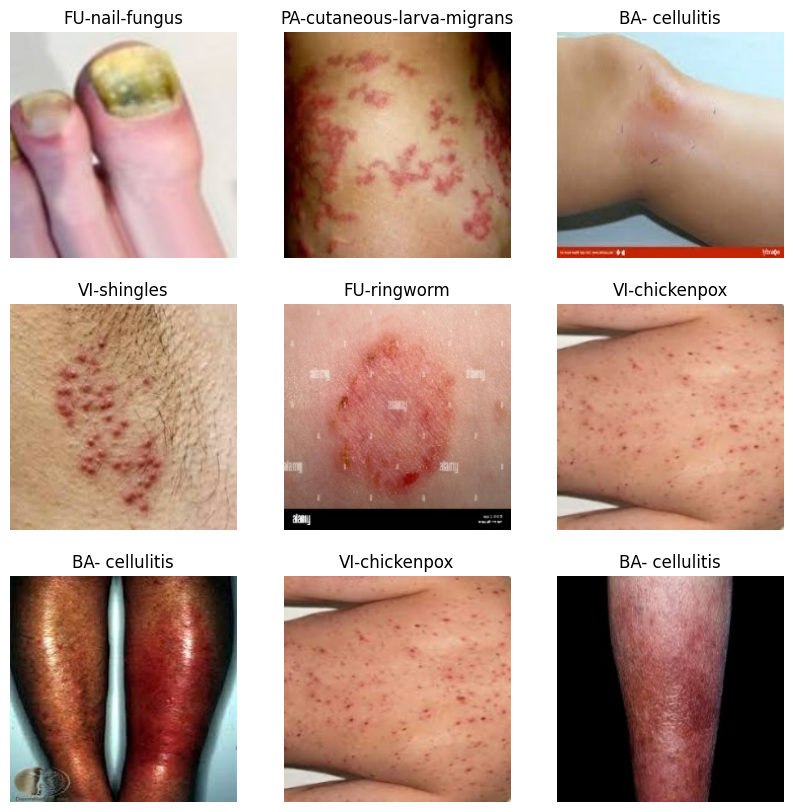

In [ ]:

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

#### Checking Batch Size


In [ ]:

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


#### Cache, Shuffle, and Prefetch the Dataset


In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [ ]:
test_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

# Step 4: Building the Model


In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

# Step 5: Data Augmentation


Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
     layers.RandomFlip("vertical") ,
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

In [ ]:

input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
batch_input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
chanDim = -1
if K.image_data_format() == "channels_first":
    input_shape = (CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    batch_input_shape = (BATCH_SIZE, CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    chanDim = 1

# Step 6: Model Architecture


We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.



In [ ]:
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=batch_input_shape)

# Step 7: Model Summary


In [ ]:
model.summary()


Model: "sequential_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_40 (Sequential)      │ (32, 224, 224, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_41 (Sequential)      │ (32, 224, 224, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (32, 222, 222, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_47 (MaxPooling2D) │ (32, 111, 111, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (32, 109, 109, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_48 (MaxPooling2D) │ (32, 54, 54, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (32, 52, 52, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_49 (MaxPooling2D) │ (32, 26, 26, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (32, 24, 24, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_50 (MaxPooling2D) │ (32, 12, 12, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (32, 10, 10, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_51 (MaxPooling2D) │ (32, 5, 5, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (32, 3, 3, 128)        │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_52 (MaxPooling2D) │ (32, 1, 1, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (32, 128)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (32, 128)              │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (32, 8)                │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 996,698 (3.80 MB)

 Trainable params: 332,232 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 664,466 (2.53 MB)

# Step 8: Compiling the Model

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Step 9: Training the Network


In [ ]:

history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=20,
)

Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.1351 - loss: 2.0788 - val_accuracy: 0.1406 - val_loss: 2.0484
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.1588 - loss: 2.0492 - val_accuracy: 0.1875 - val_loss: 2.0097
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.1473 - loss: 2.0170 - val_accuracy: 0.2344 - val_loss: 1.9161
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.2044 - loss: 1.9694 - val_accuracy: 0.3281 - val_loss: 1.8264
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.2597 - loss: 1.8999 - val_accuracy: 0.3750 - val_loss: 1.8047
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.3255 - loss: 1.8115 - val_accuracy: 0.3750 - val_loss: 1.7114
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.3416 - loss: 1.7641 - val_accuracy: 0.4062 - val_loss: 1.5093
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.3712 - loss: 1.5824 - val_accuracy: 0.4375 - v

# Step 10: Choosing the Best Model



In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Callback for saving best model based on validation accuracy
checkpoint = ModelCheckpoint(
    "best_model.h5",                # file name for saving best model
    monitor="val_accuracy",         # metric to monitor
    mode="max",                     # because higher accuracy is better
    save_best_only=True,            # only save the best one
    verbose=1
)

history = model.fit(
    train_ds,
    steps_per_epoch=47,
    epochs=100,
    validation_data=val_ds,
    callbacks=[checkpoint]
)


Epoch 1/100
23/47 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.9198 - loss: 0.1800
Epoch 1: val_accuracy improved from -inf to 0.89062, saving model to best_model.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9273 - loss: 0.1725 - val_accuracy: 0.8906 - val_loss: 0.2431
Epoch 2/100
23/47 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9730 - loss: 0.0964
Epoch 2: val_accuracy improved from 0.89062 to 0.96875, saving model to best_model.h5


47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9680 - loss: 0.1108 - val_accuracy: 0.9688 - val_loss: 0.1491
Epoch 3/100
23/47 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9487 - loss: 0.1686
Epoch 3: val_accuracy did not improve from 0.96875
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9512 - loss: 0.1517 - val_accuracy: 0.8906 - val_loss: 0.2098
Epoch 4/100
23/47 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9606 - loss: 0.1228
Epoch 4: val_accuracy did not improve from 0.96875
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9556 - loss: 0.1313 - val_accuracy: 0.9219 - val_loss: 0.2989
Epoch 5/100
23/47 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9527 - loss: 0.1559
Epoch 5: val_accuracy did not improve from 0.96875
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9483 - loss: 0.1675 - val_accuracy: 0.8750 - val_loss: 0.2899
Epoch 6/100
23/47 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9436 - loss: 0.1747
Epoch 6: val_accuracy did not improve f

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9848 - loss: 0.0589 - val_accuracy: 0.9844 - val_loss: 0.1448
Epoch 43/100
23/47 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9909 - loss: 0.0603
Epoch 43: val_accuracy did not improve from 0.98438
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9879 - loss: 0.0583 - val_accuracy: 0.9844 - val_loss: 0.1289
Epoch 44/100
23/47 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9826 - loss: 0.0620
Epoch 44: val_accuracy did not improve from 0.98438
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9762 - loss: 0.0750 - val_accuracy: 0.9062 - val_loss: 0.3392
Epoch 45/100
23/47 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9617 - loss: 0.1073
Epoch 45: val_accuracy did not improve from 0.98438
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9548 - loss: 0.1273 - val_accuracy: 0.9219 - val_loss: 0.4066
Epoch 46/100
23/47 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9336 - loss: 0.2146
Epoch 46: val_accuracy did not i

## Step 10: Accuracy of Model


In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(test_ds)
print(f"Test Accuracy: {round(scores[1],4)*100}%")

[INFO] Calculating model accuracy
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9604 - loss: 0.2637
Test Accuracy: 96.88%


# Step 11: Plotting Accuracy and Loss


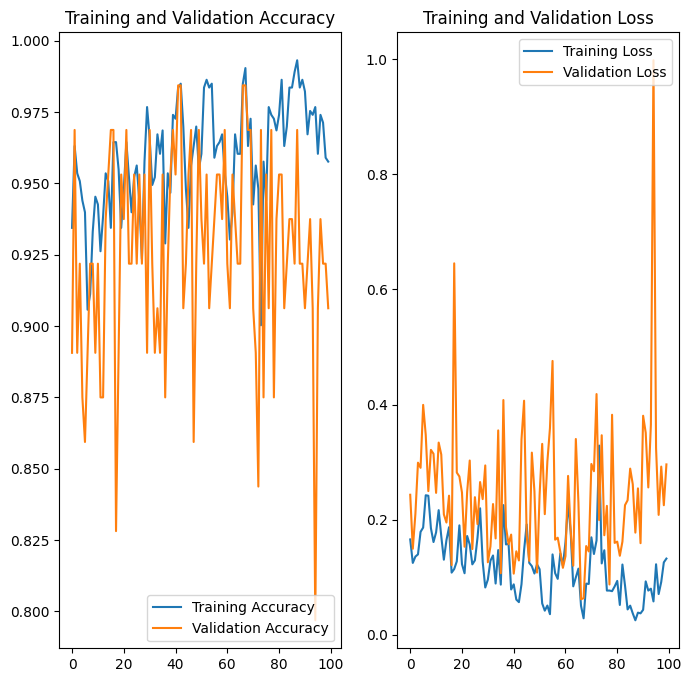

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['accuracy']))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Step 12: Predictions

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(test_ds)
print(f"Test Accuracy: {round(scores[1],4)*100}%")

[INFO] Calculating model accuracy
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9698 - loss: 0.2270
Test Accuracy: 96.88%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


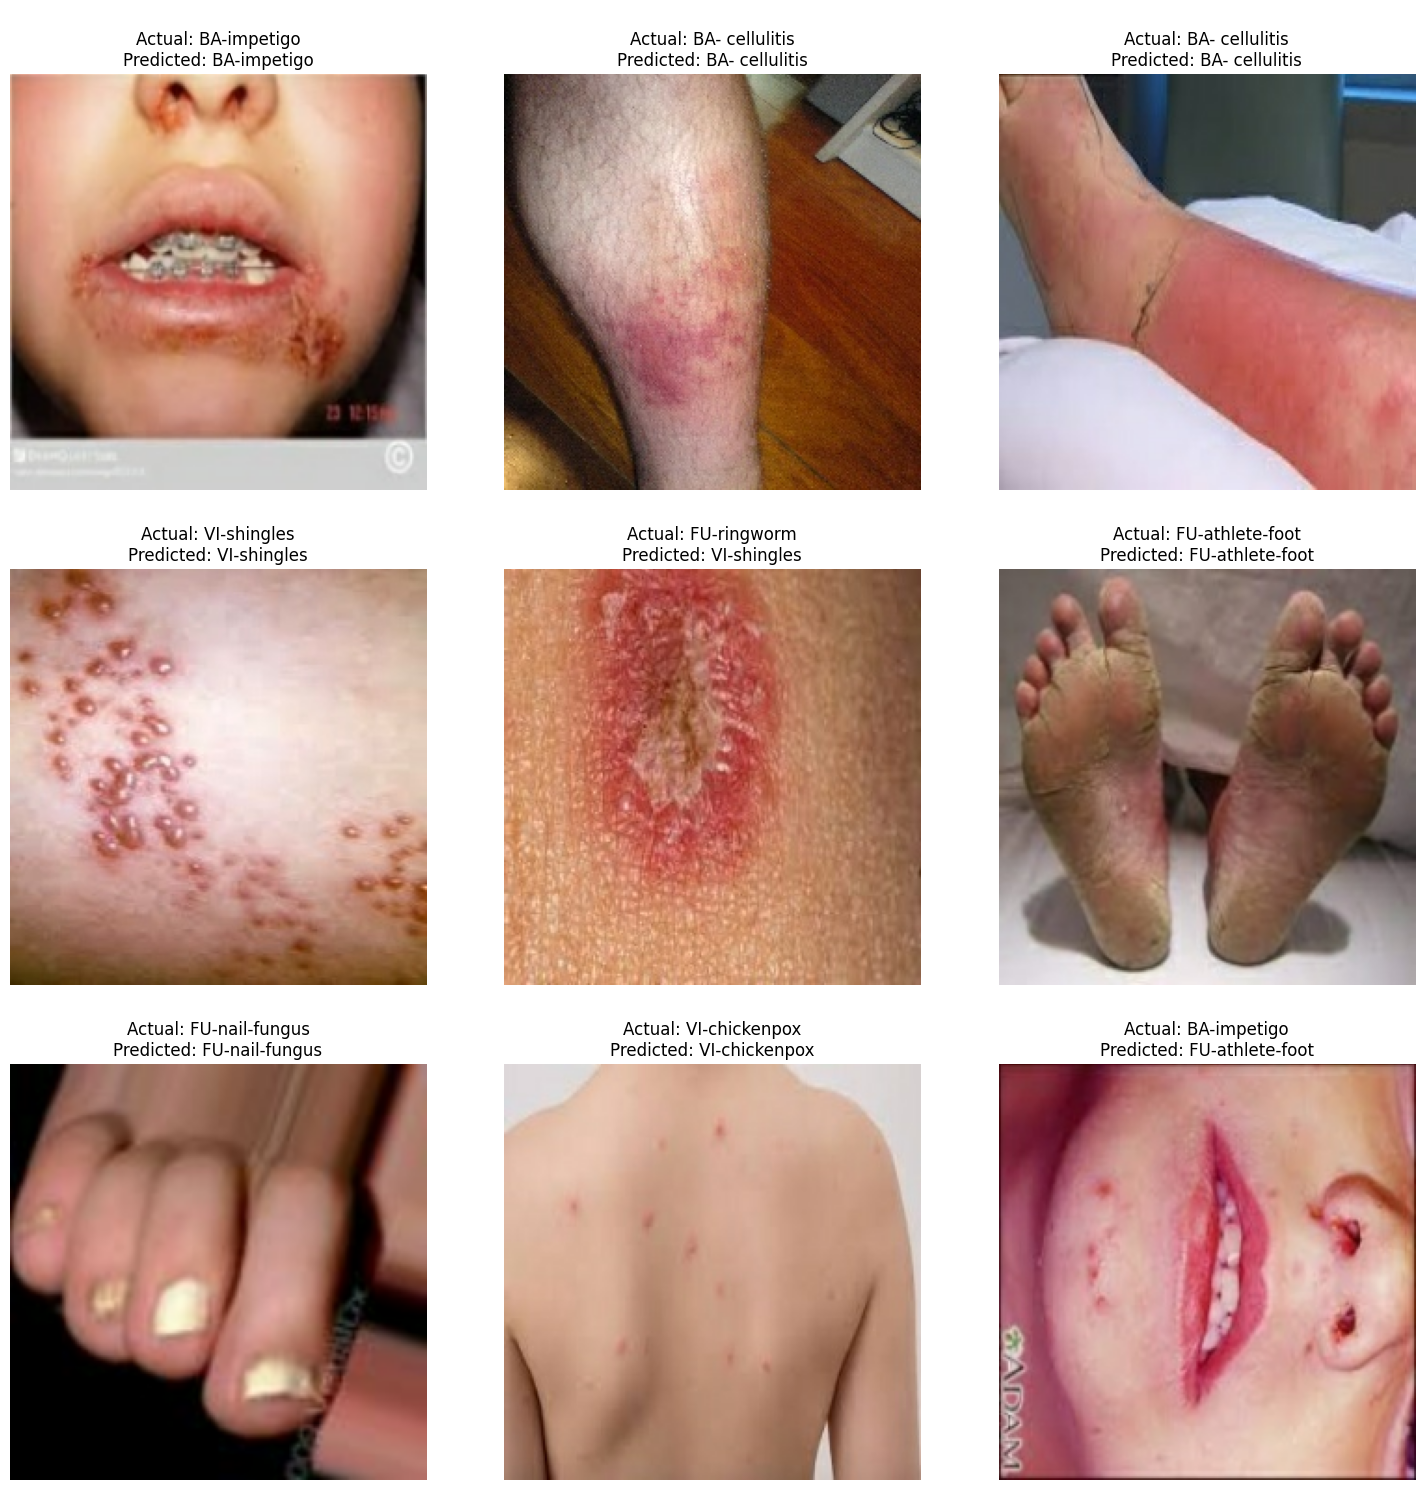

In [ ]:
import matplotlib.pyplot as plt

# Assuming test_ds is created from test_set folder like:
# test_ds = image_dataset_from_directory("dataset/test_set", ...)

# You can hardcode the folder name here since you're looping over test_ds
origin_folder = "test_set"

plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        # Assuming predict returns: (predicted_class: str, confidence: float)
        predicted_class, _ = predict(model, images[i].numpy())

        actual_class = class_names[labels[i]]
        plt.title(f"\nActual: {actual_class}\nPredicted: {predicted_class}")
        plt.axis("off")

plt.tight_layout()
plt.show()


#Step 13: Saving the Model


In [ ]:
model.save(f"/content/modle.h5")
